Making panel A; training and validation loss

In [51]:
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import ast 
from matplotlib.lines import Line2D
from scipy.stats import pearsonr
import json

smaller_size = 13
medium_size = 14
bigger_size = 16

plt.rc('font', size=bigger_size)          # controls default text sizes
plt.rc('axes', titlesize=medium_size)     # fontsize of the axes title
plt.rc('axes', labelsize=medium_size)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=smaller_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=smaller_size)    # fontsize of the tick labels
plt.rc('legend', fontsize=smaller_size)    # legend fontsize
plt.rc('figure', titlesize=bigger_size)  # fontsize of the figure title


In [52]:
#read in the record  eval file
#reads the config file; gets where the expression data is stored, pulls that out
#Using the title of the experiment from config, fetch the yhat, row matching, and training losses files
def get_paths(config_path): #uses the absolute path to the config
    
    os.chdir(os.path.dirname(config_path))
    os.chdir('..')
    os.chdir('..')
    with open(config_path, 'r') as file:
        config = json.load(file)
    os.chdir('..')
    expr_path = config['expr_file']
    expr_path = os.path.abspath(expr_path)
    os.chdir('Abdullah_kuziez')
    exp_title=config['experiment_id']

    #grab the paths using string patterns
    # go to results and check for a folder that contains the string pattern of experiment id
    results_dir = os.path.join(os.getcwd(), "Experiments", "results")
    # Find the result folder that contains the experiment id
    exp_folder = None
    for folder in os.listdir(results_dir):
        if exp_title in folder:
            exp_folder = os.path.join(results_dir, folder)
            break
    if exp_folder is None:
        raise FileNotFoundError(f"No results folder found containing experiment id: {exp_title}")

    # Find the seed folder (e.g., seed_000)
    seed_folder = None
    for folder in os.listdir(exp_folder):
        if folder.startswith("seed_"):
            seed_folder = os.path.join(exp_folder, folder)
            break
    if seed_folder is None:
        raise FileNotFoundError(f"No seed folder found in {exp_folder}")

    # Compose the paths
    # Find the yhat file that contains "6_best.y_hat.loss"
    yhat_path = None
    for file in os.listdir(seed_folder):
        if "6_best.y_hat.loss" in file:
            print('file',file)
            yhat_path = os.path.join(seed_folder, file)
            break
    if yhat_path is None:
        raise FileNotFoundError("No yhat file found containing '6_best.y_hat.loss' in seed folder.")


    row_matching_path = os.path.join(seed_folder, "random_pos.csv")
    loss_path = os.path.join(seed_folder, "record_eval.csv")



    return loss_path, expr_path, yhat_path, row_matching_path


In [53]:

def plot_train_valid_loss(loss_rel_path):
    losses = pd.read_csv(loss_rel_path, index_col=False)
    train_loss = pd.to_numeric(losses['train_loss'], errors='coerce')
    valid_loss = pd.to_numeric(losses['valid_loss'], errors='coerce')
    plt.figure(figsize=(8,5))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(valid_loss, label='Validation Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.tight_layout()

def plot_train_valid_mse(loss_rel_path):
    losses = pd.read_csv(loss_rel_path, index_col=False)
    train_mse = pd.to_numeric(losses['train_mse'], errors='coerce')
    valid_mse = pd.to_numeric(losses['valid_mse'], errors='coerce')
    plt.figure(figsize=(8,5))
    plt.plot(train_mse, label='Train MSE')
    plt.plot(valid_mse, label='Validation MSE')
    plt.xlabel('Iteration')
    plt.ylabel('MSE')
    plt.title("Training and Validation MSE")
    plt.legend()
    plt.tight_layout()


def plot_loss_curves(loss_rel_path):
    plot_train_valid_loss(loss_rel_path)
    plt.show()
    plot_train_valid_mse(loss_rel_path)
    plt.show()



In [54]:
def plot_pearson_correlation(y_path, yhat_path, row_matching_path,col_numbers_pheno=-5):
    y = pd.read_csv(y_path, header=None)
    yhat = pd.read_csv(yhat_path).iloc[:,1:]
    row_matching = pd.read_csv(row_matching_path, header=None)

    # Get test indices (assuming test set is at the end)
    test_indices = row_matching[-(yhat.shape[0]):]

    test_indices_list = test_indices[0].values

    #phenotype stuff got bastardized: fixed temporarily
    # if col_numbers_pheno==-5:
    #     col_numbers_pheno=yhat.columns.get_loc('Cell_viability%_(cck8Drug-blk)/(control-blk)*100')
    # Get all columns except the phenotype column
    all_columns = list(range(yhat.shape[1]))
    prot_columns = [col for col in all_columns if col != col_numbers_pheno]


    y_true_pheno=y.iloc[test_indices_list,col_numbers_pheno].to_numpy().flatten().astype(float)
    y_true_prots=y.iloc[test_indices_list,prot_columns].to_numpy().flatten().astype(float)
    yhat_pheno=yhat.iloc[:,col_numbers_pheno].to_numpy().flatten().astype(float)
    yhat_prots=yhat.iloc[:,prot_columns].to_numpy().flatten().astype(float)

    plt.figure(figsize=(8, 8))

    # Plot molecular nodes: light blue, slightly transparent, small dots
    plt.scatter(
        y_true_prots, yhat_prots,
        label='Proteins',
        color='#6baed6',  # light blue
        alpha=0.5,
        s=12
    )

        # Plot phenotype nodes: dark blue, slightly transparent, small dots
    plt.scatter(
        y_true_pheno, yhat_pheno,
        label='Phenotype',
        color='#08306b',  # dark blue
        alpha=0.7,
        s=12
    )

    # Plot y=x line
    all_true = np.concatenate((y_true_pheno, y_true_prots))
    all_pred = np.concatenate((yhat_pheno, yhat_prots))
    min_val = min(np.min(all_true), np.min(all_pred))
    max_val = max(np.max(all_true), np.max(all_pred))
    plt.plot([min_val, max_val], [min_val, max_val], color='gray', linestyle='--', linewidth=1, label='y = x')
    # Calculate Pearson's r for phenotype and proteins
    r_pheno, _ = pearsonr(y_true_pheno, yhat_pheno)
    r_prots, _ = pearsonr(y_true_prots, yhat_prots)
    # Write on the graph
    # Calculate single Pearson's r for all points
    r_all, _ = pearsonr(all_true, all_pred)
    plt.text(
        0.95, 0.05,
        f"Pearson r: {r_all:.3f}",
        transform=plt.gca().transAxes,
        fontsize=11,
        verticalalignment='bottom',
        horizontalalignment='right',
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7)
    )

    plt.legend()
    plt.xlabel('True Expression')
    plt.ylabel('Predicted Expression')

    plt.title('Correlation between experiment and prediction in test set:')
    plt.tight_layout()
    return

file 6_best.y_hat.loss.0.03349114049226046.csv


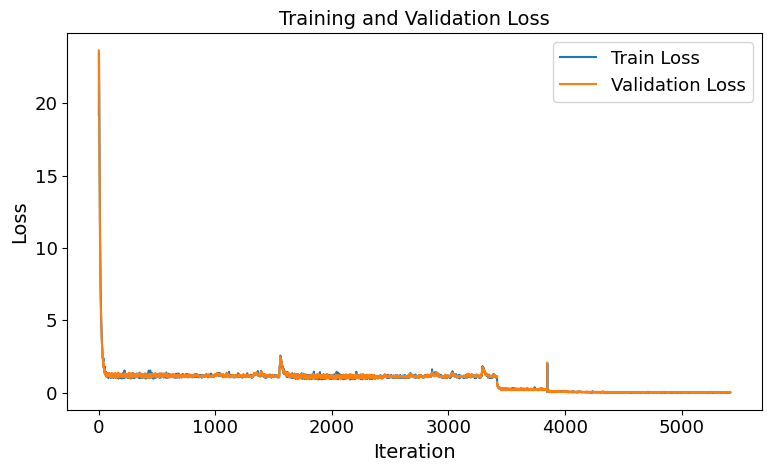

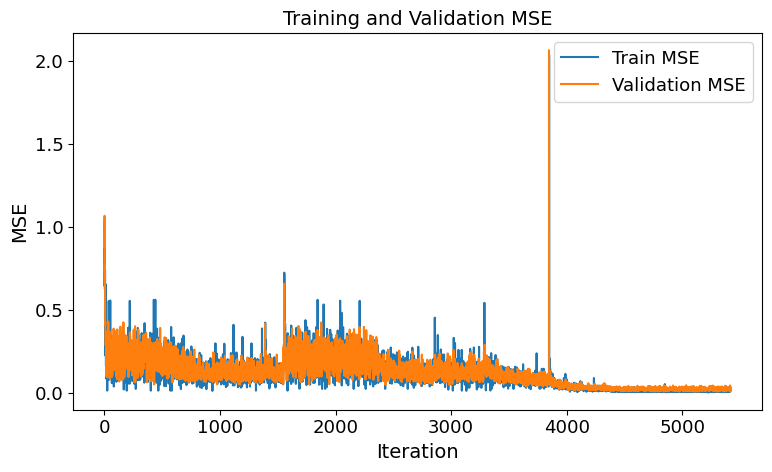

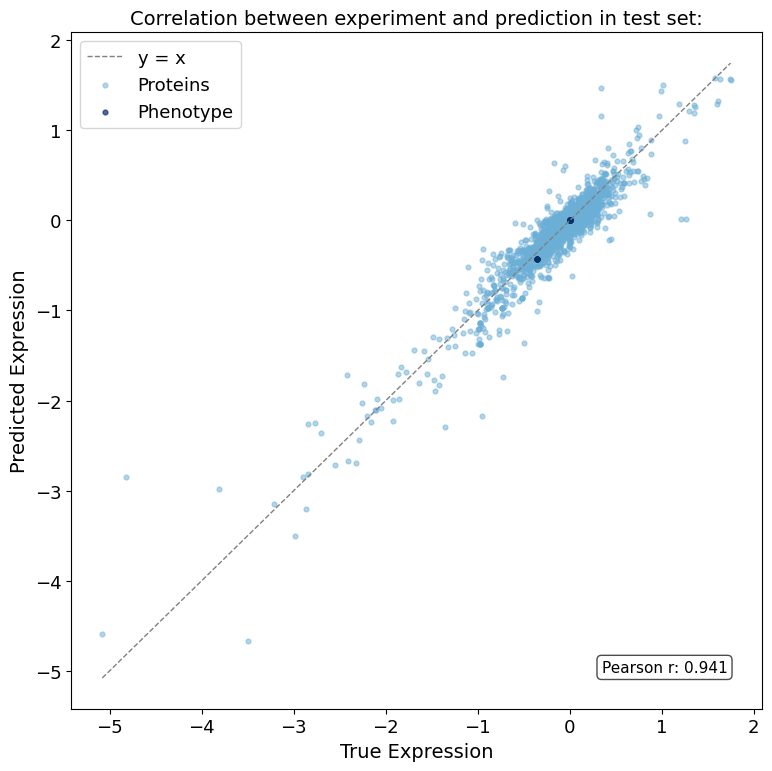

In [55]:
config_path=r'/home/abk397/cellbox_torch/Abdullah_kuziez/Experiments/configs/control_rndm_part.json'
loss_path, y_path, yhat_path, row_matching_path= get_paths(config_path)
plot_loss_curves(loss_path)
plt.show()
plot_pearson_correlation(y_path, yhat_path, row_matching_path)
plt.show()
